## Investment Portfolio Management

In [1]:
# Imprting libraries
import numpy as np # provides ways to work with large multidimensional arrays
import matplotlib.pyplot as plt # plotting
import yfinance as yf
import datetime as dt
import pandas as pd
# import mplfinance as mpf
import time

# used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

import statsmodels.api as sm
import seaborn as sns

from statsmodels.tsa.ar_model import AutoReg, ar_select_order

### Dates and other constants

In [20]:
PATH = '/home/johnadi/Desktop/projects/projects-from-yt-channel-derek-banas/python-for-finance/Stock List/'

# Start Date Defaults
S_YEAR = 2017
S_MONTH = 1
S_DAY = 3
S_DATE_STR = "2017-01-03"
S_DATE_DATETIME = dt.datetime(S_YEAR, S_MONTH, S_DAY)

# End Date Defaults
E_YEAR = 2021
E_MONTH = 8
E_DAY = 18
E_DATE_STR = "2021-08-18"
E_DATE_DATETIME = dt.datetime(E_YEAR, E_MONTH, E_DAY)

risk_free_rate = 0.0125 # approximate 10 year bound rate

### Get Stock File Names in a list

In [3]:
files = [x for x in listdir(PATH) if isfile(join(PATH, x))]
tickers = [os.path.splitext(x)[0] for x in files]
tickers.sort()
tickers

['A',
 'AAL',
 'AAPL',
 'ABBV',
 'ABT',
 'ACGL',
 'ACN',
 'ADBE',
 'ADI',
 'ADM',
 'ADP',
 'ADSK',
 'AEE',
 'AEP',
 'AES',
 'AFL',
 'AIG',
 'AIZ',
 'AJG',
 'AKAM',
 'ALB',
 'ALGN',
 'ALL',
 'ALLE',
 'AMAT',
 'AMCR',
 'AMD',
 'AME',
 'AMGN',
 'AMP',
 'AMT',
 'AMZN',
 'ANET',
 'ANSS',
 'AON',
 'AOS',
 'APA',
 'APD',
 'APH',
 'APTV',
 'ARE',
 'ATO',
 'AVB',
 'AVGO',
 'AVY',
 'AWK',
 'AXON',
 'AXP',
 'AZO',
 'BA',
 'BAC',
 'BALL',
 'BAX',
 'BBWI',
 'BBY',
 'BDX',
 'BEN',
 'BF-B',
 'BG',
 'BIIB',
 'BIO',
 'BK',
 'BKNG',
 'BKR',
 'BLDR',
 'BLK',
 'BMY',
 'BR',
 'BRK-B',
 'BRO',
 'BSX',
 'BWA',
 'BX',
 'BXP',
 'C',
 'CAG',
 'CAH',
 'CAT',
 'CB',
 'CBOE',
 'CBRE',
 'CCI',
 'CCL',
 'CDNS',
 'CDW',
 'CE',
 'CEG',
 'CF',
 'CFG',
 'CHD',
 'CHRW',
 'CHTR',
 'CI',
 'CINF',
 'CL',
 'CLX',
 'CMA',
 'CMCSA',
 'CME',
 'CMG',
 'CMI',
 'CMS',
 'CNC',
 'CNP',
 'COF',
 'COO',
 'COP',
 'COR',
 'COST',
 'CPAY',
 'CPB',
 'CPRT',
 'CPT',
 'CRL',
 'CRM',
 'CSCO',
 'CSGP',
 'CSX',
 'CTAS',
 'CTLT',
 'CTRA',
 'CTS

### Function that returns a dataframe from a CSV

In [5]:
def get_df_from_csv(folder, ticker):
    try:
        df = pd.read_csv(folder + ticker + '.csv', index_col='Date', parse_dates=True)
    except FileNotFoundError:
        pass
        print('File Does not Exist')
    else:
        return df        

### Merge Multiple Stocks in One Dataframe by column Name

In [10]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()

    for x in tickers:
        df = get_df_from_csv(PATH, x)
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]

    return mult_df

### Markowitz Portfolio Optimization

Harry Markowitz proved that you could make what is called an efficient portfolio. This is a portfolio that optimizes return while also minimizing risk. We do not benefit from analyzing individual securities at the same rate as if we instead considered a portfolio of stocks. 

We do this by creating portfolios with stocks that are not correlated. We want to calculate expected results by analyzing the returns of each stock multiplied by its weight. 

w1r1 + w2r2 = rp

The standard deviation of the portfolio is found this way. Sum multiple calculations starting by finding the product of the first securities weight squared times its standard deviation squared. The middle is 2 times the correlation coefficient between the stocks. And, finally add those to the weight squared times the standard deviation squared for the second security. 

(w1q1 + w1q2)^2  = w1^2*σ1^2 + 2*w1*σ1*w2*σ2*p1 + w2^2*σ2^2

### Plotting an Efficient Frontier

#### Stock Portfolio

In [8]:
# Picking some companies
port_list = ["GNRC", "DXCM", "AMD", "NFLX","COST", "TGT", "AES", "MSCI", "NEM", "AMT", "HES"]

#### Merge all stock price data

In [11]:
mult_df = merge_df_by_column_name('Adj Close', '2018-01-01', '2021-09-01', *port_list)
mult_df

,GNRC,DXCM,AMD,NFLX,COST,TGT,AES,MSCI,NEM,AMT,HES
Date,,,,,,,,,,,
2018-01-02,48.029999,14.497500,10.980000,201.070007,170.075974,57.744240,8.811598,119.980003,31.304489,121.941406,43.369633
2018-01-03,49.730000,14.520000,11.550000,205.050003,172.117020,57.351475,8.803501,121.803032,31.041983,122.416664,44.774490
2018-01-04,50.070000,13.062500,12.120000,205.630005,170.780411,56.224438,8.771108,123.720024,31.386530,120.628098,45.853062
2018-01-05,50.410000,13.315000,11.880000,209.990005,169.561172,56.822105,8.803501,125.007378,31.501369,121.405708,47.276062
2018-01-08,49.529999,13.860000,12.280000,212.050003,170.220474,57.360027,8.803501,125.176521,31.468554,122.701782,47.575161
...,...,...,...,...,...,...,...,...,...,...,...
2021-08-26,427.470001,129.264999,107.269997,550.119995,431.093872,232.029190,21.903042,606.663391,50.576065,261.936951,65.108009
2021-08-27,437.109985,130.177505,111.400002,558.919983,432.082062,232.234238,22.196672,612.186279,51.969292,264.082947,67.474693
2021-08-30,442.700012,130.384995,111.320000,566.179993,437.445404,232.401993,22.114086,620.782043,51.361984,269.799347,66.730873


#### Plotting Growth of Investments over Total Dataset

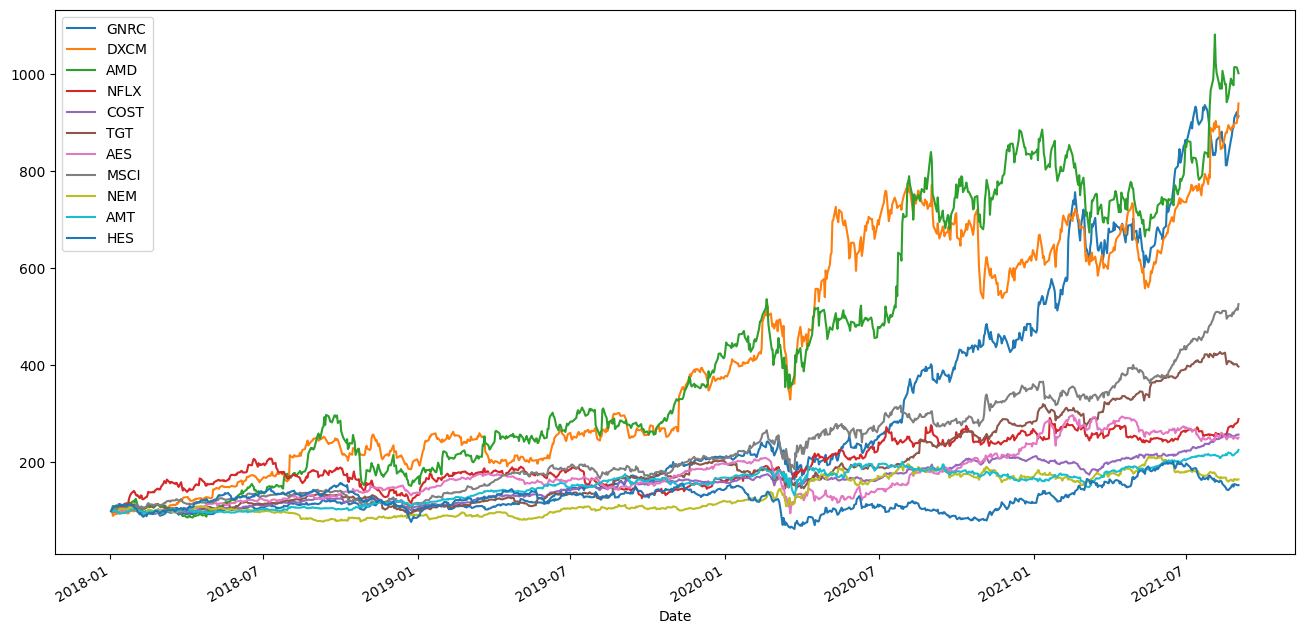

In [13]:
(mult_df / mult_df.iloc[0] * 100).plot(figsize=(16,8))
plt.show()

#### Mean Returns 

In [14]:
returns = np.log(mult_df / mult_df.shift(1))
mean_ret = returns.mean()*252  # 252 is the average trading days per year
mean_ret

GNRC    0.604585
DXCM    0.612335
AMD     0.629813
NFLX    0.290521
COST    0.258560
TGT     0.377284
AES     0.251720
MSCI    0.453818
NEM     0.137083
AMT     0.222875
HES     0.116705
dtype: float64

#### Covariance

In [15]:
returns.cov()*252

,GNRC,DXCM,AMD,NFLX,COST,TGT,AES,MSCI,NEM,AMT,HES
GNRC,0.158401,0.060093,0.086753,0.051811,0.036250,0.041692,0.065567,0.068083,0.025379,0.042728,0.080427
DXCM,0.060093,0.235217,0.093342,0.064466,0.029388,0.030245,0.043783,0.080858,0.020990,0.037071,0.057491
AMD,0.086753,0.093342,0.312689,0.102435,0.047315,0.057834,0.055249,0.094907,0.035414,0.041165,0.083068
NFLX,0.051811,0.064466,0.102435,0.169629,0.038811,0.031664,0.032497,0.064222,0.014136,0.030983,0.043144
COST,0.036250,0.029388,0.047315,0.038811,0.048775,0.034066,0.025723,0.036643,0.013120,0.030300,0.024974
TGT,0.041692,0.030245,0.057834,0.031664,0.034066,0.097695,0.038300,0.034639,0.009389,0.028609,0.040771
AES,0.065567,0.043783,0.055249,0.032497,0.025723,0.038300,0.144149,0.062109,0.021894,0.042260,0.093299
MSCI,0.068083,0.080858,0.094907,0.064222,0.036643,0.034639,0.062109,0.121926,0.026370,0.047477,0.069502
NEM,0.025379,0.020990,0.035414,0.014136,0.013120,0.009389,0.021894,0.026370,0.107236,0.020739,0.029890
AMT,0.042728,0.037071,0.041165,0.030983,0.030300,0.028609,0.042260,0.047477,0.020739,0.080782,0.037918


#### Correlation

In [16]:
returns.corr()

,GNRC,DXCM,AMD,NFLX,COST,TGT,AES,MSCI,NEM,AMT,HES
GNRC,1.000000,0.311323,0.389807,0.316079,0.412406,0.335149,0.433908,0.489908,0.194726,0.377725,0.372127
DXCM,0.311323,1.000000,0.344182,0.322736,0.274372,0.199516,0.237777,0.477466,0.132163,0.268929,0.218291
AMD,0.389807,0.344182,1.000000,0.444777,0.383127,0.330896,0.260231,0.486065,0.193395,0.259011,0.273558
NFLX,0.316079,0.322736,0.444777,1.000000,0.426688,0.245968,0.207823,0.446563,0.104813,0.264681,0.192904
COST,0.412406,0.274372,0.383127,0.426688,1.000000,0.493499,0.306777,0.475167,0.181414,0.482709,0.208237
TGT,0.335149,0.199516,0.330896,0.245968,0.493499,1.000000,0.322745,0.317380,0.091733,0.322040,0.240209
AES,0.433908,0.237777,0.260231,0.207823,0.306777,0.322745,1.000000,0.468491,0.176093,0.391617,0.452525
MSCI,0.489908,0.477466,0.486065,0.446563,0.475167,0.317380,0.468491,1.000000,0.230618,0.478391,0.366541
NEM,0.194726,0.132163,0.193395,0.104813,0.181414,0.091733,0.176093,0.230618,1.000000,0.222820,0.168086
AMT,0.377725,0.268929,0.259011,0.264681,0.482709,0.322040,0.391617,0.478391,0.222820,1.000000,0.245677


#### Generate random weights equal to 1

In [17]:
# Generate 11 random variables that sum to 1
weights = np.random.random(11)
weights /= np.sum(weights)
print('Weights :', weights)
print('Total Weight :', np.sum(weights))

Weights : [0.01633282 0.20628511 0.02130707 0.13641934 0.00873194 0.1223983
 0.08850224 0.00985741 0.17917563 0.08410391 0.12688624]
Total Weight : 1.0


#### Calculate Return of Portfolio

In [18]:
# provide return of portfolio using random weights over the whole dataset
np.sum(weights*returns.mean())*252

0.3225451017351751

#### Calculate Volatility

In [19]:
np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights)))

0.23958598543623955

#### Analyzing Returns and Risks of 10000 Combinations

In [21]:
p_ret = []
p_vol = []
p_SR = []
p_wt = []

for x in range(10000):
    p_weights = np.random.random(11)
    p_weights /= np.sum(p_weights)

    ret_1 = np.sum(p_weights * returns.mean()) * 252
    p_ret.append(ret_1)
    vol_1 = np.sqrt(np.dot(p_weights.T, np.dot(returns.cov() * 252, p_weights)))
    p_vol.append(vol_1)

    SR_1 = (ret_1 - risk_free_rate) / vol_1

    p_SR.append(SR_1)

    p_wt.append(p_weights)

p_ret = np.array(p_ret)
p_vol = np.array(p_vol)
p_SR = np.array(p_SR)
p_wt = np.array(p_wt)

p_ret, p_vol, p_SR, p_wt 

(array([0.27474798, 0.35572055, 0.43715017, ..., 0.34291072, 0.40455381,
        0.3505788 ]),
 array([0.23478176, 0.22729235, 0.26353624, ..., 0.2423923 , 0.24993455,
        0.24808267]),
 array([1.11698617, 1.51004005, 1.611354  , ..., 1.36312384, 1.56862592,
        1.36276669]),
 array([[0.02143237, 0.09087009, 0.01582163, ..., 0.18495698, 0.02502792,
         0.16353076],
        [0.15874799, 0.02604517, 0.04031124, ..., 0.06555118, 0.09646841,
         0.03461638],
        [0.14078115, 0.18861893, 0.12130223, ..., 0.01284189, 0.03560836,
         0.00708519],
        ...,
        [0.05453134, 0.06181418, 0.10681312, ..., 0.12661917, 0.07040491,
         0.12551297],
        [0.14310532, 0.01273356, 0.17484523, ..., 0.15178029, 0.12694983,
         0.00610263],
        [0.0100752 , 0.11905241, 0.15296104, ..., 0.11255143, 0.04276474,
         0.1384013 ]]))

### Plotting the Efficient Frontier

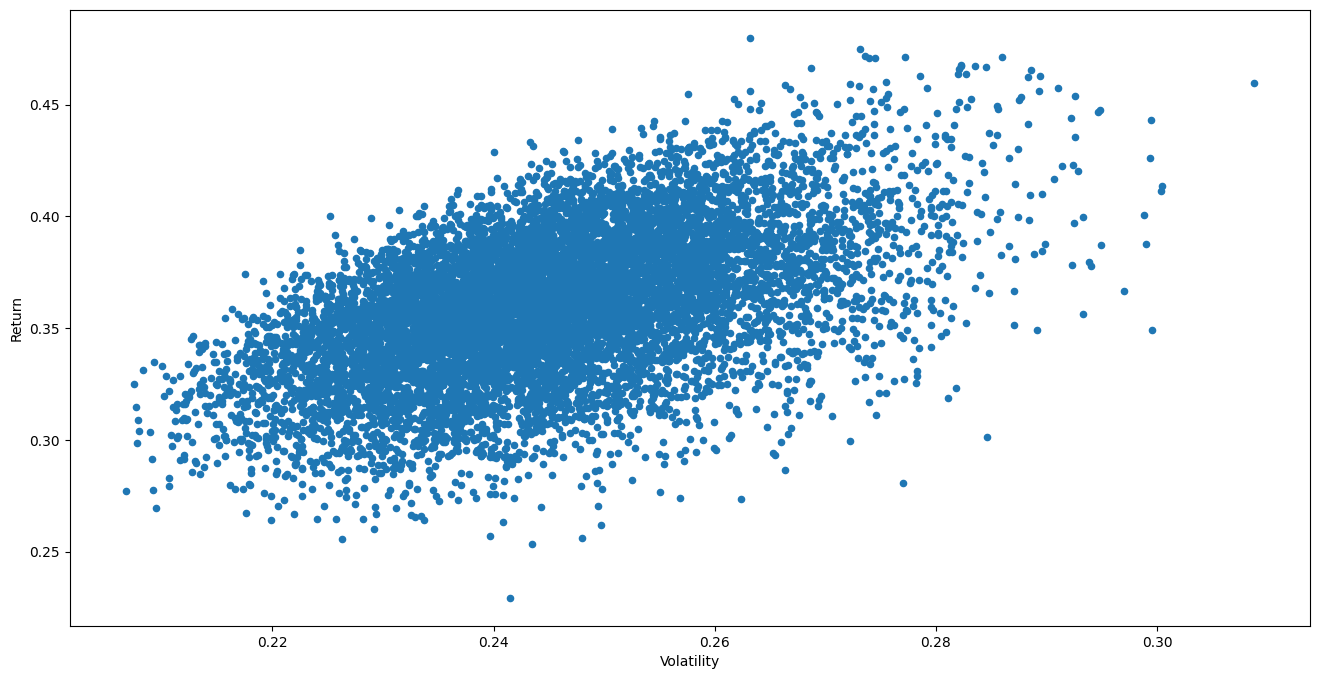

In [23]:
ports = pd.DataFrame({'Return': p_ret, 'Volatility': p_vol})
ports.plot(x='Volatility', y='Return', kind='scatter', figsize=(16,8))
plt.show()

### Sharpe Ratio

People want to maximize returns while avoiding as much risk as possible. William Sharpe created the Sharpe Ratio to find the portfolio that provides the best return for the lowest amount of risk. 

Sharpe ratio = ri -rf / σi 

rf = risk free rate
ri = rate of return of the stock
σi = standard deviation of the stock

As return increases so does the Sharpe Ratio, but as Standard Deviation increases the Sharpe Ratio decreases. 

In [24]:
SR_idx = np.argmax(p_SR)
i = 0
while i < 11:
    print("Stock : %s : %2.2f" % (port_list[i], (p_wt[4296][i]*100)))
    i += 1
print("\nVolatility :", p_vol[4296])
print("\nReturn :", p_ret[4296])

Stock : GNRC : 15.66
Stock : DXCM : 10.68
Stock : AMD : 14.39
Stock : NFLX : 2.00
Stock : COST : 6.19
Stock : TGT : 5.50
Stock : AES : 5.95
Stock : MSCI : 11.88
Stock : NEM : 11.44
Stock : AMT : 5.00
Stock : HES : 11.30

Volatility : 0.2610645772111081

Return : 0.4022102066826658
